## Step 1: Load and Inspect the Data

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Load the dataset
df = pd.read_csv('fake_job_postings.csv')

## Step 2: Preliminary Data Inspection


In [2]:
# Inspect the first few rows and the class distribution
print(df.head())
print(df['fraudulent'].value_counts())

   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo

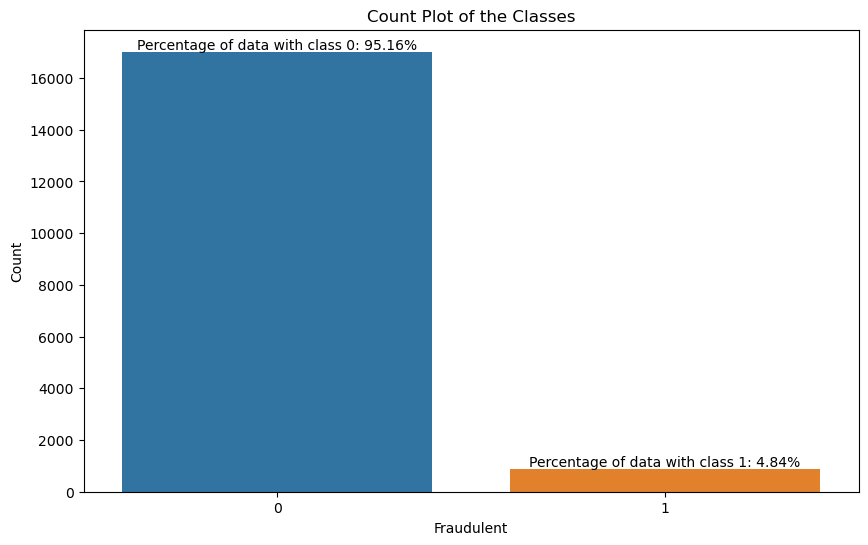

In [24]:
# Get count of each class
class_counts = df['fraudulent'].value_counts()
total_samples = df.shape[0]

# Calculate percentages
class_0_percentage = (class_counts[0] / total_samples) * 100
class_1_percentage = (class_counts[1] / total_samples) * 100

# Plotting
plt.figure(figsize=(10, 6))

# Count plot
sns.countplot(data=df, x='fraudulent')
plt.title('Count Plot of the Classes')
plt.xlabel('Fraudulent')
plt.ylabel('Count')

# Displaying percentages
plt.text(0, class_counts[0] + 100, f"Percentage of data with class 0: {class_0_percentage:.2f}%", ha='center')
plt.text(1, class_counts[1] + 100, f"Percentage of data with class 1: {class_1_percentage:.2f}%", ha='center')

plt.show()

In [3]:
#check how which column and how many null value the dataset have 
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

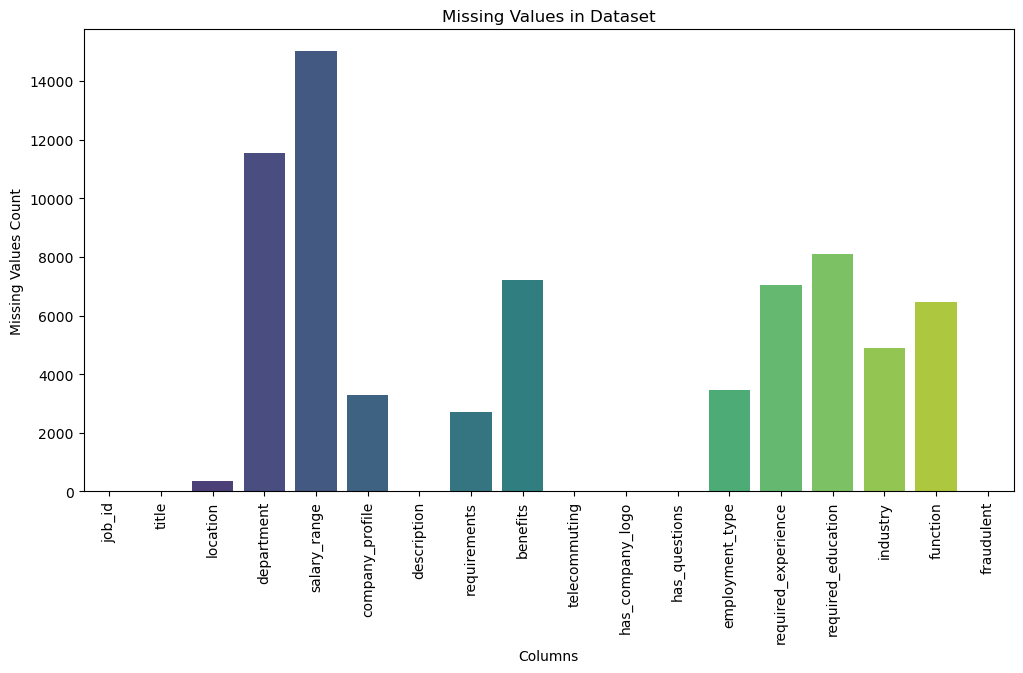

In [29]:
# Find missing values
missing_values = df.isnull().sum()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.title('Missing Values in Dataset')
plt.xlabel('Columns')
plt.ylabel('Missing Values Count')
plt.xticks(rotation=90)
plt.show()

## Step 3: Data Cleaning and Preparation


In [4]:
# Fill missing values with empty strings and combine relevant columns for NLP
df.fillna("", inplace=True)
df['text'] = df['title'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']


## Step 4: Install and Load spaCy

In [5]:
import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

## Step 5: Text Preprocessing with spaCy


In [6]:
# Tokenize, remove stop words, punctuation, and lemmatize
processed_text = [" ".join([token.lemma_ for token in nlp(text) if not token.is_stop and not token.is_punct and token.is_alpha]) for text in df['text']]

## Step 6: Visualize the Text Data with WordCloud

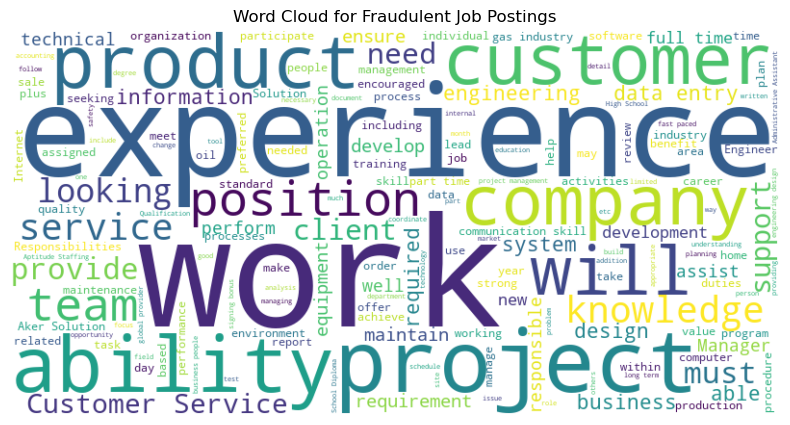

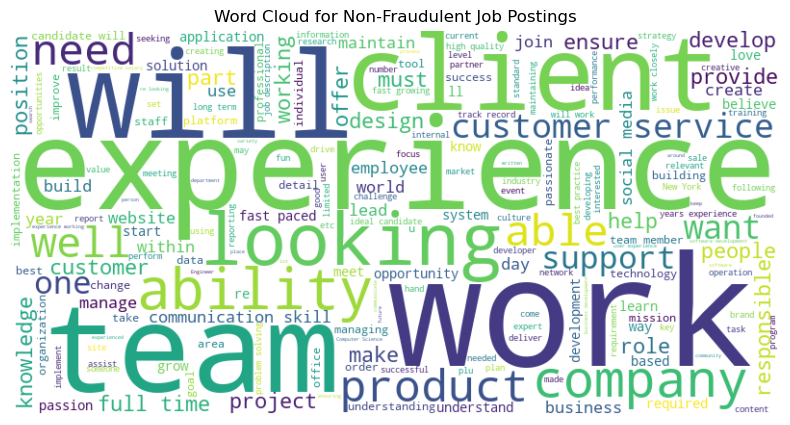

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate WordCloud for fraudulent job postings
fraudulent_text = ' '.join(df[df['fraudulent'] == 1]['text'])
fraudulent_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fraudulent_text)

# Generate WordCloud for non-fraudulent job postings
non_fraudulent_text = ' '.join(df[df['fraudulent'] == 0]['text'])
non_fraudulent_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_fraudulent_text)

# Display the WordCloud for fraudulent job postings
plt.figure(figsize=(10, 5))
plt.imshow(fraudulent_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fraudulent Job Postings')
plt.show()

# Display the WordCloud for non-fraudulent job postings
plt.figure(figsize=(10, 5))
plt.imshow(non_fraudulent_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Fraudulent Job Postings')
plt.show()


In [8]:
import spacy
from collections import Counter

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]

# Initialize counters
fraudulent_word_freq = Counter()
non_fraudulent_word_freq = Counter()

# Process and count words for each fraudulent posting individually
for text in df[df['fraudulent'] == 1]['text']:
    fraudulent_words = preprocess_text(text)
    fraudulent_word_freq.update(fraudulent_words)

# Process and count words for each non-fraudulent posting individually
for text in df[df['fraudulent'] == 0]['text']:
    non_fraudulent_words = preprocess_text(text)
    non_fraudulent_word_freq.update(non_fraudulent_words)


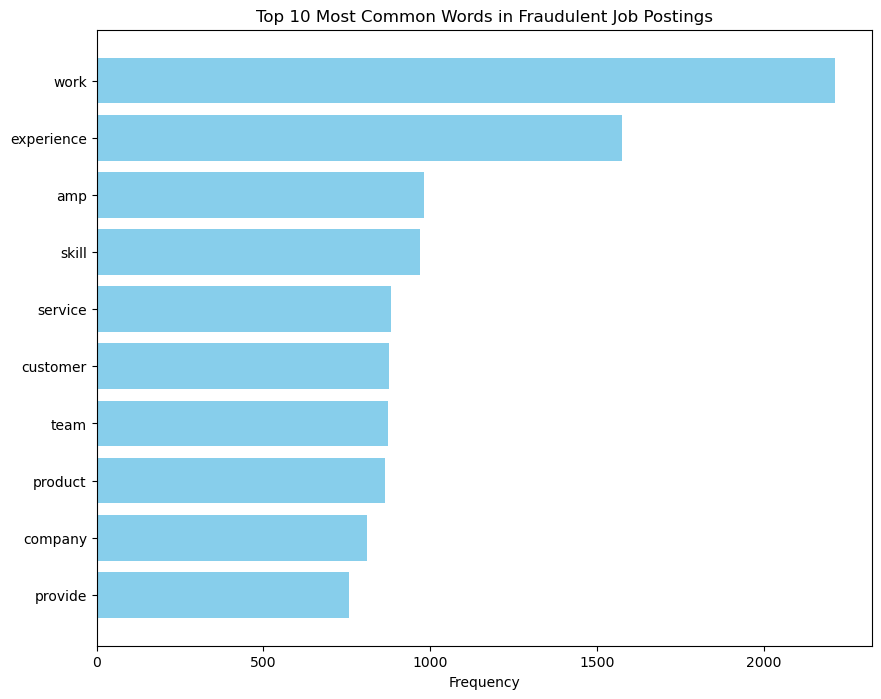

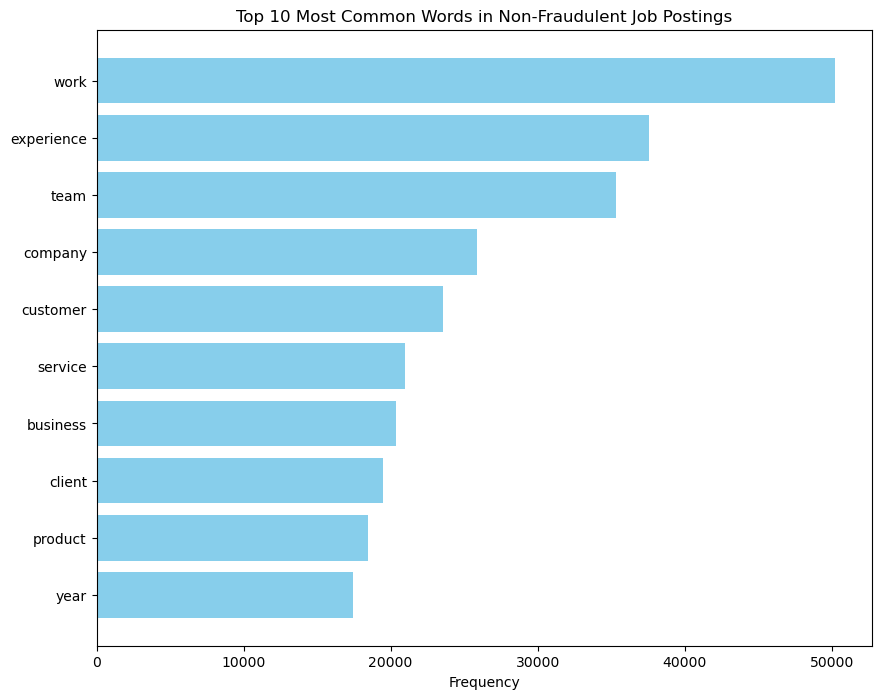

In [9]:
import matplotlib.pyplot as plt

# Function to plot the top N most common words from the Counter object
def plot_top_words(word_freq, title, n=10):
    # Get the most common words and their counts
    common_words = word_freq.most_common(n)
    words, counts = zip(*common_words)
    
    # Create a bar graph
    plt.figure(figsize=(10, 8))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.gca().invert_yaxis()  # Display the highest counts at the top
    plt.show()

# Plot for fraudulent job postings
plot_top_words(fraudulent_word_freq, 'Top 10 Most Common Words in Fraudulent Job Postings')

# Plot for non-fraudulent job postings
plot_top_words(non_fraudulent_word_freq, 'Top 10 Most Common Words in Non-Fraudulent Job Postings')


## Step 7: Feature Extraction with TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the processed text to a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X = tfidf_vectorizer.fit_transform(processed_text)
y = df['fraudulent']


## Step 8: Split the Data into Training and Testing Sets

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


## Step 9: Balance the Data with SMOTE

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [13]:
import numpy as np

# Count the occurrences of each class in the resampled target variable
unique, counts = np.unique(y_train_resampled, return_counts=True)
resampled_class_distribution = dict(zip(unique, counts))

print(resampled_class_distribution)


{0: 12767, 1: 12767}


## Step 10: Train a Model with Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [15]:
from sklearn.metrics import classification_report, accuracy_score

# Predict and evaluate the model
y_pred = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9816554809843401
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4247
           1       1.00      0.63      0.77       223

    accuracy                           0.98      4470
   macro avg       0.99      0.82      0.88      4470
weighted avg       0.98      0.98      0.98      4470



## Trying to improve recall value for fraudulent job postings

## Step 1: Feature Engineering
First, we'll explore if additional features can be extracted from the text or other columns to help the model better distinguish fraudulent postings.

In [16]:
# Assuming 'df' is your original DataFrame

# Feature engineering: you could create new features such as text length, word count, etc.
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

## Step 2: Text Preprocessing and Vectorization
Continue with text preprocessing, including TF-IDF vectorization, which can be adjusted to include n-grams to capture more context.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Adjust TF-IDF vectorization to include bi-grams or tri-grams
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_text = tfidf_vectorizer.fit_transform(df['text'])

# If you have additional numerical features, combine them with the TF-IDF features
from scipy.sparse import hstack
X_combined = hstack([X_text, df[['text_length', 'word_count']].values])


## Step 3: Train-Test Split
Split your data into training and testing sets to ensure model evaluation is done on unseen data.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, df['fraudulent'], test_size=0.25, random_state=42)

## Step 4: Apply SMOTE
Use SMOTE to balance the training data, focusing on increasing the minority class representation.

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


## Step 5: Model Training and Hyperparameter Tuning
Train a model and consider tuning parameters to improve recall. You can use grid search or other optimization techniques to find the best parameters.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model and parameters for grid search
rfc = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'criterion': ['gini', 'entropy']
}

# Grid search focusing on recall
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model after grid search
best_model = grid_search.best_estimator_


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4247
           1       0.99      0.64      0.78       223

    accuracy                           0.98      4470
   macro avg       0.99      0.82      0.88      4470
weighted avg       0.98      0.98      0.98      4470

